# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


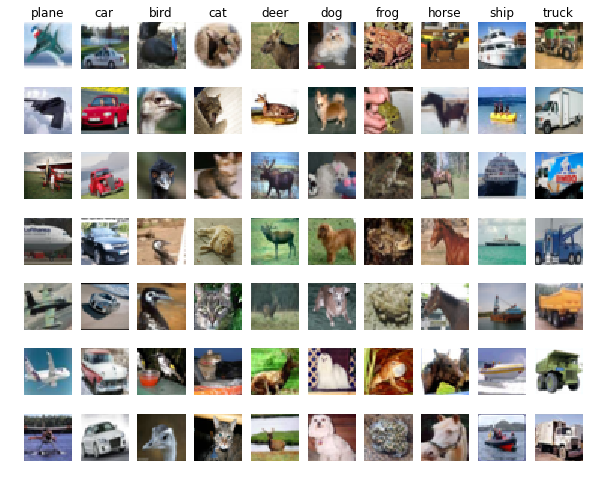

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


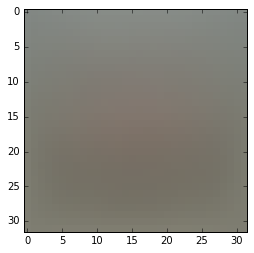

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [34]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print 'loss: %f' % (loss, )

loss: 9.289384


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [33]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 18.976238 analytic: 18.976238, relative error: 2.555540e-12
numerical: -12.486300 analytic: -12.486300, relative error: 1.034540e-11
numerical: 0.112925 analytic: 0.112925, relative error: 1.682971e-09
numerical: -1.447732 analytic: -1.447732, relative error: 2.508892e-10
numerical: -26.505447 analytic: -26.517321, relative error: 2.239484e-04
numerical: 18.573996 analytic: 18.573996, relative error: 5.140572e-12
numerical: -4.627099 analytic: -4.700807, relative error: 7.901848e-03
numerical: -26.813568 analytic: -26.851507, relative error: 7.069618e-04
numerical: -17.936061 analytic: -17.936061, relative error: 1.260530e-11
numerical: 18.805457 analytic: 18.805457, relative error: 1.832083e-11
numerical: -24.862369 analytic: -24.831564, relative error: 6.199053e-04
numerical: 8.833932 analytic: 8.833932, relative error: 1.783941e-11
numerical: 13.279707 analytic: 13.279707, relative error: 4.096372e-11
numerical: 17.713905 analytic: 17.713905, relative error: 2.665933e-11


### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** Presumably because the loss function isn't strictly differentiable (where the score s_j - s_y_i = /delta), if we try to calculate the numerical gradient at that point we will get a slightly wrong answer. But it isn't concerning because it just adds a very small amount of noise to the gradient overall.

In [51]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 9.289384e+00 computed in 0.081524s
Vectorized loss: 9.289384e+00 computed in 0.005595s
difference: -0.000000


In [53]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.085492s
Vectorized loss and gradient: computed in 0.009845s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [58]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 803.950973
iteration 100 / 1500: loss 292.339725
iteration 200 / 1500: loss 109.921936
iteration 300 / 1500: loss 43.465263
iteration 400 / 1500: loss 18.742657
iteration 500 / 1500: loss 10.008865
iteration 600 / 1500: loss 6.974490
iteration 700 / 1500: loss 5.796667
iteration 800 / 1500: loss 5.757346
iteration 900 / 1500: loss 5.665150
iteration 1000 / 1500: loss 4.779257
iteration 1100 / 1500: loss 5.259593
iteration 1200 / 1500: loss 5.359416
iteration 1300 / 1500: loss 5.311283
iteration 1400 / 1500: loss 5.087775
That took 5.324616s


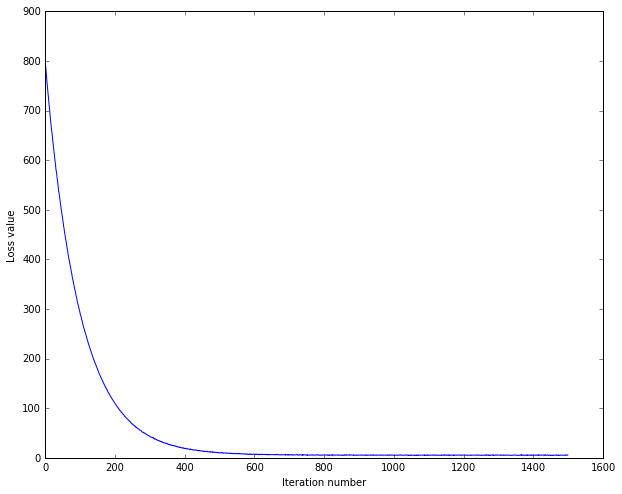

In [59]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [68]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

(49000, 10)
(49000,)
training accuracy: 0.368959
(1000, 10)
(1000,)
validation accuracy: 0.375000


iteration 0 / 5000: loss 327.386643
iteration 100 / 5000: loss 298.550935
iteration 200 / 5000: loss 272.123620
iteration 300 / 5000: loss 250.607282
iteration 400 / 5000: loss 229.088832
iteration 500 / 5000: loss 213.342570
iteration 600 / 5000: loss 196.556568
iteration 700 / 5000: loss 180.609026
iteration 800 / 5000: loss 167.591394
iteration 900 / 5000: loss 154.772702
iteration 1000 / 5000: loss 143.284376
iteration 1100 / 5000: loss 132.613346
iteration 1200 / 5000: loss 122.489188
iteration 1300 / 5000: loss 114.459623
iteration 1400 / 5000: loss 105.288423
iteration 1500 / 5000: loss 97.118491
iteration 1600 / 5000: loss 89.393662
iteration 1700 / 5000: loss 83.163931
iteration 1800 / 5000: loss 76.692070
iteration 1900 / 5000: loss 71.435531
iteration 2000 / 5000: loss 65.860729
iteration 2100 / 5000: loss 60.615874
iteration 2200 / 5000: loss 57.668116
iteration 2300 / 5000: loss 52.626871
iteration 2400 / 5000: loss 49.807490
iteration 2500 / 5000: loss 46.154680
iteration

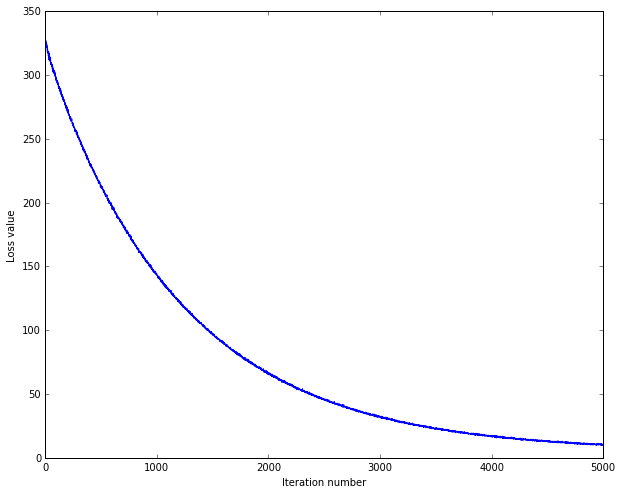

iteration 0 / 5000: loss 642.475239
iteration 100 / 5000: loss 541.585409
iteration 200 / 5000: loss 459.150230
iteration 300 / 5000: loss 389.885479
iteration 400 / 5000: loss 333.265530
iteration 500 / 5000: loss 284.781196
iteration 600 / 5000: loss 242.309221
iteration 700 / 5000: loss 206.822310
iteration 800 / 5000: loss 177.178540
iteration 900 / 5000: loss 151.653348
iteration 1000 / 5000: loss 129.836006
iteration 1100 / 5000: loss 111.334745
iteration 1200 / 5000: loss 95.507059
iteration 1300 / 5000: loss 82.173459
iteration 1400 / 5000: loss 70.425289
iteration 1500 / 5000: loss 60.404234
iteration 1600 / 5000: loss 52.208453
iteration 1700 / 5000: loss 45.233106
iteration 1800 / 5000: loss 39.573259
iteration 1900 / 5000: loss 34.027125
iteration 2000 / 5000: loss 29.999517
iteration 2100 / 5000: loss 26.250045
iteration 2200 / 5000: loss 22.767966
iteration 2300 / 5000: loss 20.197849
iteration 2400 / 5000: loss 18.124966
iteration 2500 / 5000: loss 16.406977
iteration 26

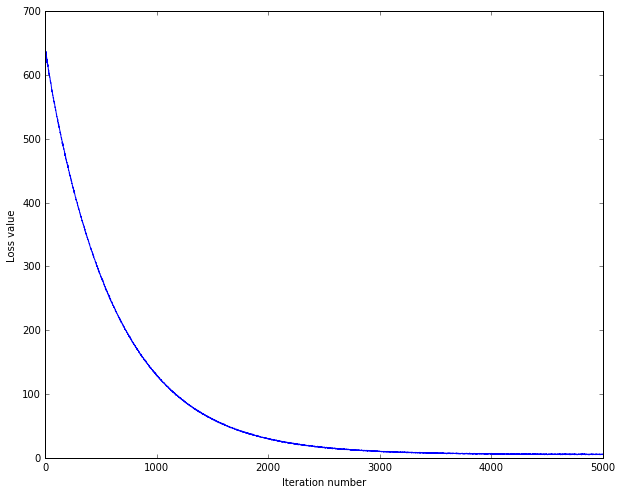

iteration 0 / 5000: loss 1267.763215
iteration 100 / 5000: loss 914.229860
iteration 200 / 5000: loss 664.859587
iteration 300 / 5000: loss 482.714199
iteration 400 / 5000: loss 350.853018
iteration 500 / 5000: loss 255.914394
iteration 600 / 5000: loss 186.871097
iteration 700 / 5000: loss 137.650249
iteration 800 / 5000: loss 100.774304
iteration 900 / 5000: loss 74.440473
iteration 1000 / 5000: loss 55.561635
iteration 1100 / 5000: loss 41.788119
iteration 1200 / 5000: loss 31.621231
iteration 1300 / 5000: loss 24.900940
iteration 1400 / 5000: loss 18.850048
iteration 1500 / 5000: loss 15.185178
iteration 1600 / 5000: loss 13.544115
iteration 1700 / 5000: loss 10.767028
iteration 1800 / 5000: loss 8.880895
iteration 1900 / 5000: loss 8.268297
iteration 2000 / 5000: loss 7.278872
iteration 2100 / 5000: loss 7.513694
iteration 2200 / 5000: loss 6.433122
iteration 2300 / 5000: loss 6.407288
iteration 2400 / 5000: loss 5.953788
iteration 2500 / 5000: loss 5.916186
iteration 2600 / 5000:

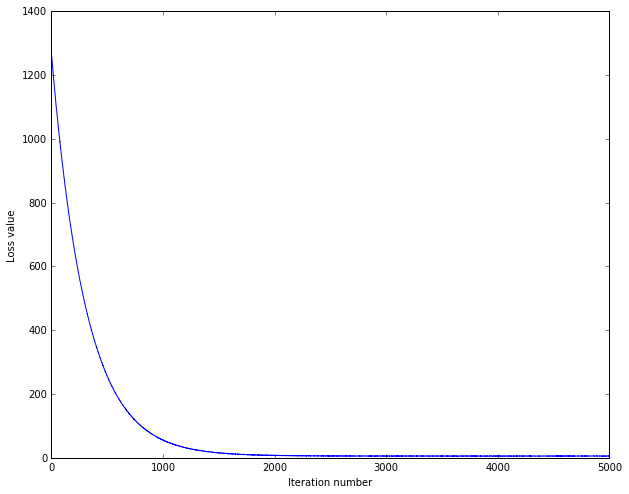

iteration 0 / 5000: loss 323.423529
iteration 100 / 5000: loss 271.846491
iteration 200 / 5000: loss 232.096596
iteration 300 / 5000: loss 196.848086
iteration 400 / 5000: loss 166.394251
iteration 500 / 5000: loss 143.375310
iteration 600 / 5000: loss 121.573875
iteration 700 / 5000: loss 104.781093
iteration 800 / 5000: loss 89.861260
iteration 900 / 5000: loss 76.904833
iteration 1000 / 5000: loss 65.996978
iteration 1100 / 5000: loss 56.673227
iteration 1200 / 5000: loss 49.268391
iteration 1300 / 5000: loss 42.181645
iteration 1400 / 5000: loss 36.481515
iteration 1500 / 5000: loss 31.954705
iteration 1600 / 5000: loss 27.669588
iteration 1700 / 5000: loss 24.526717
iteration 1800 / 5000: loss 21.500866
iteration 1900 / 5000: loss 19.245546
iteration 2000 / 5000: loss 16.781713
iteration 2100 / 5000: loss 14.918022
iteration 2200 / 5000: loss 13.597554
iteration 2300 / 5000: loss 12.473143
iteration 2400 / 5000: loss 10.478784
iteration 2500 / 5000: loss 10.431140
iteration 2600 /

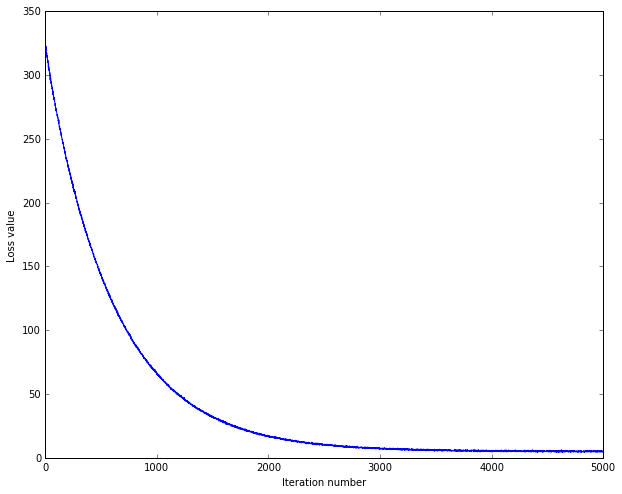

iteration 0 / 5000: loss 641.969324
iteration 100 / 5000: loss 458.365985
iteration 200 / 5000: loss 331.452309
iteration 300 / 5000: loss 241.464422
iteration 400 / 5000: loss 176.581300
iteration 500 / 5000: loss 129.892990
iteration 600 / 5000: loss 94.857735
iteration 700 / 5000: loss 69.815948
iteration 800 / 5000: loss 52.609601
iteration 900 / 5000: loss 39.053711
iteration 1000 / 5000: loss 29.171530
iteration 1100 / 5000: loss 22.793863
iteration 1200 / 5000: loss 17.801587
iteration 1300 / 5000: loss 14.587496
iteration 1400 / 5000: loss 11.981458
iteration 1500 / 5000: loss 9.856339
iteration 1600 / 5000: loss 8.945492
iteration 1700 / 5000: loss 7.796011
iteration 1800 / 5000: loss 7.253286
iteration 1900 / 5000: loss 6.224885
iteration 2000 / 5000: loss 6.359494
iteration 2100 / 5000: loss 5.727504
iteration 2200 / 5000: loss 5.751134
iteration 2300 / 5000: loss 5.407265
iteration 2400 / 5000: loss 5.655784
iteration 2500 / 5000: loss 5.485539
iteration 2600 / 5000: loss 5

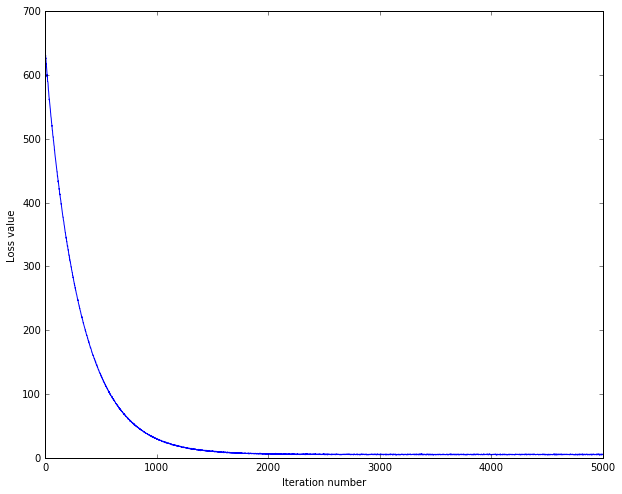

iteration 0 / 5000: loss 1254.018260
iteration 100 / 5000: loss 657.939854
iteration 200 / 5000: loss 349.091687
iteration 300 / 5000: loss 184.654547
iteration 400 / 5000: loss 99.451057
iteration 500 / 5000: loss 54.840346
iteration 600 / 5000: loss 31.414997
iteration 700 / 5000: loss 19.260705
iteration 800 / 5000: loss 12.693194
iteration 900 / 5000: loss 9.980532
iteration 1000 / 5000: loss 7.519131
iteration 1100 / 5000: loss 6.545107
iteration 1200 / 5000: loss 6.026459
iteration 1300 / 5000: loss 5.582142
iteration 1400 / 5000: loss 5.540322
iteration 1500 / 5000: loss 5.721101
iteration 1600 / 5000: loss 5.653972
iteration 1700 / 5000: loss 6.003679
iteration 1800 / 5000: loss 5.866949
iteration 1900 / 5000: loss 5.238496
iteration 2000 / 5000: loss 4.804109
iteration 2100 / 5000: loss 5.201680
iteration 2200 / 5000: loss 5.371961
iteration 2300 / 5000: loss 5.756892
iteration 2400 / 5000: loss 5.460474
iteration 2500 / 5000: loss 5.377150
iteration 2600 / 5000: loss 5.842616

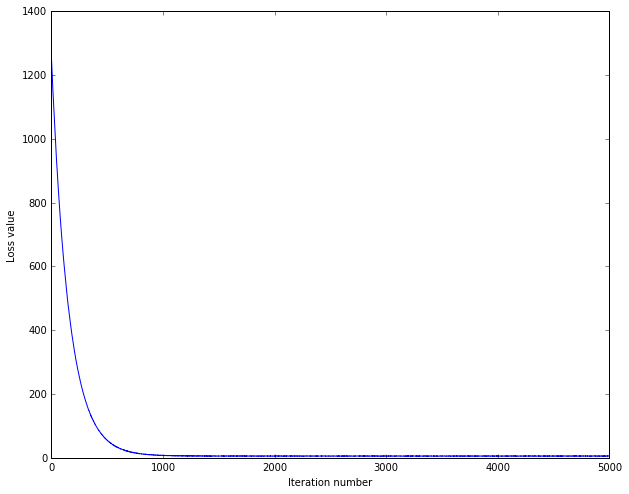

iteration 0 / 5000: loss 335.978683
iteration 100 / 5000: loss 231.856130
iteration 200 / 5000: loss 168.776201
iteration 300 / 5000: loss 125.168020
iteration 400 / 5000: loss 90.490517
iteration 500 / 5000: loss 66.653794
iteration 600 / 5000: loss 50.403431
iteration 700 / 5000: loss 37.555937
iteration 800 / 5000: loss 27.933224
iteration 900 / 5000: loss 21.672641
iteration 1000 / 5000: loss 16.968296
iteration 1100 / 5000: loss 13.778066
iteration 1200 / 5000: loss 11.934248
iteration 1300 / 5000: loss 9.439631
iteration 1400 / 5000: loss 8.067339
iteration 1500 / 5000: loss 7.147743
iteration 1600 / 5000: loss 6.531347
iteration 1700 / 5000: loss 6.459490
iteration 1800 / 5000: loss 5.980402
iteration 1900 / 5000: loss 5.673952
iteration 2000 / 5000: loss 5.690850
iteration 2100 / 5000: loss 5.334527
iteration 2200 / 5000: loss 4.693451
iteration 2300 / 5000: loss 5.400473
iteration 2400 / 5000: loss 4.988136
iteration 2500 / 5000: loss 5.019362
iteration 2600 / 5000: loss 5.713

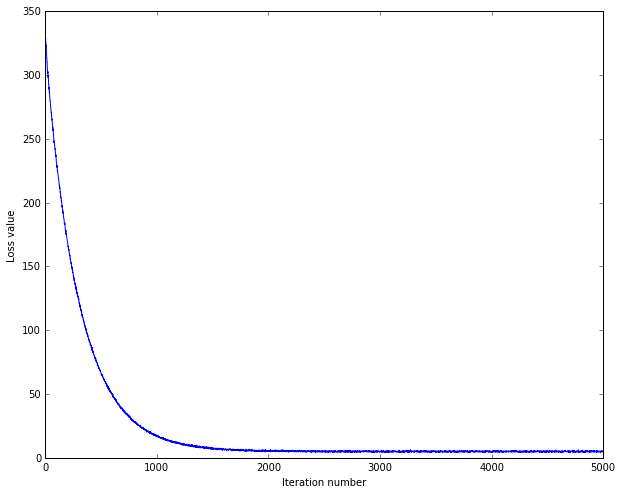

iteration 0 / 5000: loss 631.684583
iteration 100 / 5000: loss 328.690807
iteration 200 / 5000: loss 174.175242
iteration 300 / 5000: loss 93.504861
iteration 400 / 5000: loss 51.425510
iteration 500 / 5000: loss 29.584097
iteration 600 / 5000: loss 18.020406
iteration 700 / 5000: loss 11.765496
iteration 800 / 5000: loss 8.515372
iteration 900 / 5000: loss 7.075042
iteration 1000 / 5000: loss 5.922758
iteration 1100 / 5000: loss 5.767988
iteration 1200 / 5000: loss 5.487168
iteration 1300 / 5000: loss 5.683305
iteration 1400 / 5000: loss 4.974875
iteration 1500 / 5000: loss 4.897970
iteration 1600 / 5000: loss 5.020011
iteration 1700 / 5000: loss 5.518674
iteration 1800 / 5000: loss 5.179120
iteration 1900 / 5000: loss 5.427019
iteration 2000 / 5000: loss 5.265338
iteration 2100 / 5000: loss 5.029981
iteration 2200 / 5000: loss 5.458427
iteration 2300 / 5000: loss 5.599190
iteration 2400 / 5000: loss 5.430460
iteration 2500 / 5000: loss 5.804550
iteration 2600 / 5000: loss 5.558782
it

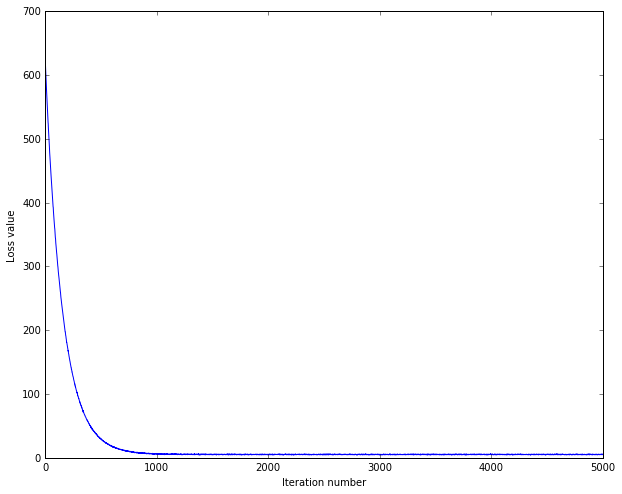

iteration 0 / 5000: loss 1254.355202
iteration 100 / 5000: loss 345.539140
iteration 200 / 5000: loss 98.846379
iteration 300 / 5000: loss 31.226415
iteration 400 / 5000: loss 13.057455
iteration 500 / 5000: loss 7.281417
iteration 600 / 5000: loss 6.288794
iteration 700 / 5000: loss 5.113179
iteration 800 / 5000: loss 5.279470
iteration 900 / 5000: loss 5.581949
iteration 1000 / 5000: loss 5.981231
iteration 1100 / 5000: loss 5.464039
iteration 1200 / 5000: loss 5.979426
iteration 1300 / 5000: loss 5.706266
iteration 1400 / 5000: loss 5.253513
iteration 1500 / 5000: loss 5.306501
iteration 1600 / 5000: loss 5.450840
iteration 1700 / 5000: loss 5.671350
iteration 1800 / 5000: loss 5.490771
iteration 1900 / 5000: loss 5.796292
iteration 2000 / 5000: loss 5.267943
iteration 2100 / 5000: loss 5.429094
iteration 2200 / 5000: loss 5.653338
iteration 2300 / 5000: loss 5.683725
iteration 2400 / 5000: loss 6.151897
iteration 2500 / 5000: loss 5.682822
iteration 2600 / 5000: loss 5.683423
itera

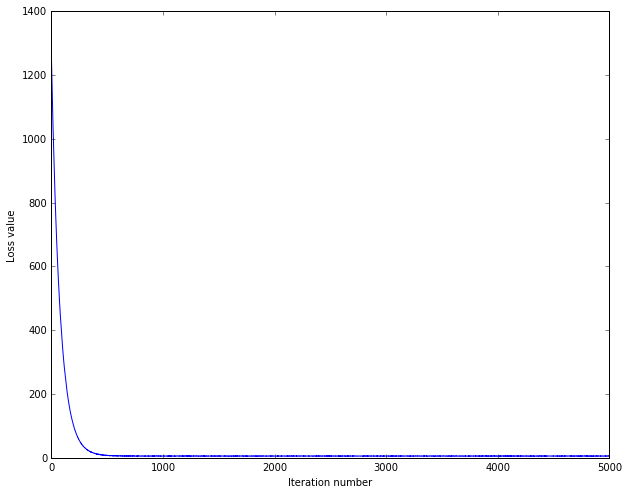

lr 2.000000e-08 reg 2.000000e+04 train accuracy: 0.376878 val accuracy: 0.381000
lr 2.000000e-08 reg 4.000000e+04 train accuracy: 0.379163 val accuracy: 0.391000
lr 2.000000e-08 reg 8.000000e+04 train accuracy: 0.368510 val accuracy: 0.378000
lr 4.000000e-08 reg 2.000000e+04 train accuracy: 0.386224 val accuracy: 0.388000
lr 4.000000e-08 reg 4.000000e+04 train accuracy: 0.378041 val accuracy: 0.382000
lr 4.000000e-08 reg 8.000000e+04 train accuracy: 0.365551 val accuracy: 0.373000
lr 8.000000e-08 reg 2.000000e+04 train accuracy: 0.388163 val accuracy: 0.391000
lr 8.000000e-08 reg 4.000000e+04 train accuracy: 0.376449 val accuracy: 0.382000
lr 8.000000e-08 reg 8.000000e+04 train accuracy: 0.363735 val accuracy: 0.368000
best validation accuracy achieved during cross-validation: 0.391000


In [98]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [2e-8, 4e-8, 8e-8]
regularization_strengths = [2e4, 4e4, 8e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=5000, verbose=True)
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            print 'Validation Accuracy: {}'.format(val_accuracy)
            best_val = val_accuracy
            best_svm = svm
        plt.plot(loss_hist)
        plt.xlabel('Iteration number')
        plt.ylabel('Loss value')
        plt.show()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

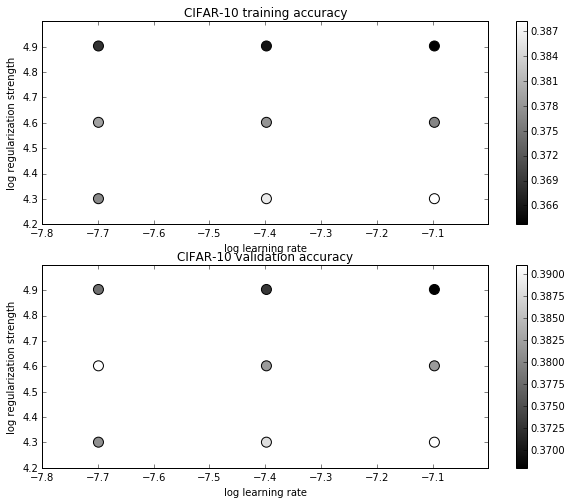

In [99]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [100]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.376000


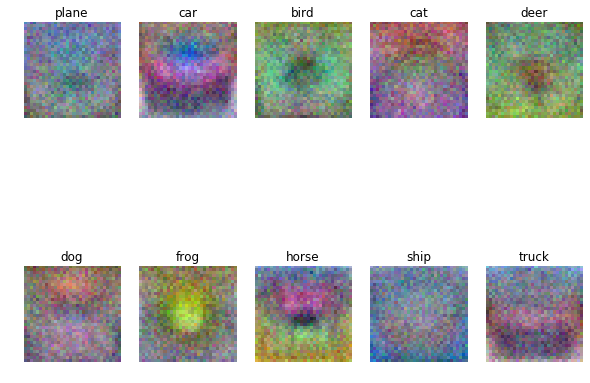

In [101]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** As might be expected for an SVM classifier, the weights are seizing mostly on blobs of color in the center of the image with a small amount of structure. E.g. the car weights look like a red trapezoid with darker shadows toward the bottom. Frog weights are very green, deer is brown (with a green background), etc.